## Document Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
print(os.path.exists("books/HSC26-Bangla1st-Paper.pdf"))

True


In [6]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore

load_dotenv()

PDF_FILE_PATH = "books/HSC26-Bangla1st-Paper.pdf"

loader = PyPDFLoader(PDF_FILE_PATH)
documents = loader.load()

print(f"Successfully loaded {len(documents)} pages from the PDF.")

Successfully loaded 55 pages from the PDF.


Chunking the Documents

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100
)

In [8]:
all_chunks = splitter.split_documents(documents=documents)
len(all_chunks)

156

In [10]:
all_chunks[1].page_content

'সম্পেক\x00\n \nজ্ঞানলাভ\n \nকরেব।\n \nপ্রাক\n-\nমূল্যায়ন\n \n১।\n \nঅনুপেমর\n \nবাবা\n \nকী\n \nকের\n \nজীিবকা\n \nিনব\x00াহ\n \nকরেতন\n?\n \nক\n)\n \nডাক্তাির\n \nখ\n)\n \nওকালিত\n \nগ\n)\n \nমাস্টাির\n \nঘ\n)\n \nব্যবসা\n \n২।\n \nমামােক\n \nভাগ্য\n \n\x00দবতার\n \nপ্রধান\n \nএেজন্ট\n \nবলার\n \nকারণ\n,\n \nতার\n-\n \nক\n)\n \nপ্রিতপিত্ত\n \nখ\n)\n \nপ্রভাব\n \nগ\n)\n \nিবচক্ষণতা\n \nঘ\n)\n \nকূট\n \nবুিদ্ধ\n \nিনেচর\n \nঅনুেচ্ছদটি\n \nপেড়\n \n৩\n \nও\n \n৪\n \nসংখ্যক\n \nপ্রেশ্নর\n \nউত্তর\n \nদাও।'

Embedding Model From HF

In [11]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [12]:
import getpass
import os

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [13]:
len(embeddings.embed_query("সময়"))

768

Pinecone Vector DB

In [14]:
from pinecone import Pinecone
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [15]:
pc = Pinecone(api_key=pinecone_api_key)

In [16]:
from pinecone import ServerlessSpec 

index_name = "10ms-db-bangla-book"

if not pc.has_index(index_name):
    pc.create_index(
    name=index_name,
    dimension=768,
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

Load the DB

In [17]:
index = pc.Index(index_name)
index

In [18]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

In [19]:
vector_store.add_documents(documents=all_chunks)

['eba7784c-46b2-48ba-b490-fac41b82d2f0',
 '03579d29-de97-4172-98b0-b1ed9a684a4a',
 '010de01a-ad57-4385-9a89-111168145eff',
 '8c8cf7d3-2da5-4a67-b0a5-4f0cca379ea1',
 '9b8fedaa-6806-4316-a388-efbc3c134d4f',
 'ca974d28-1512-44fa-9f0a-983166b50373',
 '5583fb43-0449-4bcb-847e-2b564f2ec53b',
 'f364077d-6843-434f-82ad-250f57491648',
 '5b7637a2-c6e5-43d1-87e1-402a7be72afe',
 'b03797fb-20b0-41b2-862c-e2128cd2ba21',
 '84169f51-76bf-4701-9806-dde339670ce6',
 '5ef90d97-ecf2-48bb-ad4e-de1fd9437a39',
 'a9935874-2583-498c-8b8f-8f0c3e660bca',
 'a6171edb-ea5c-40e9-a849-38c7a80afad2',
 '74f324e0-6d70-400c-85b7-b06907163603',
 '5a9a37cf-cf28-4af5-9614-3bed77217918',
 '5efb006a-2b66-4d5e-97c4-8a6a30214552',
 '2f59670c-32c7-4b7c-84d6-c3815629dbc1',
 '95956618-4167-4570-96c8-931145f86a0f',
 '258d76d8-f1e2-4049-ab8a-dc7391f367d7',
 'c5377bdd-b5dd-4505-83ab-36af829fa6da',
 'd72fb999-111a-4087-ad51-c5edb82e6e6c',
 'b41e2c78-1aa2-4804-a6a6-e55644b0ab92',
 'b3711fcb-7649-47ab-8ce8-4da4bd0b899e',
 'edd68e48-b50b-

In [20]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [21]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 5
    }
)

In [22]:
response = retriever.invoke("বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?")
response

[Document(id='f364077d-6843-434f-82ad-250f57491648', metadata={'creationdate': '', 'creator': 'PyPDF', 'page': 3.0, 'page_label': '4', 'producer': 'Skia/PDF m140 Google Docs Renderer', 'source': 'books/HSC26-Bangla1st-Paper.pdf', 'title': 'HSC26-Bangla1st-Paper', 'total_pages': 55.0}, page_content='অিভিষক্ত  অিভেষক  করা  হেয়েছ  এমন  \nসওগাঁদ  উপেঢৗকন।  \x00ভট।  \n\x00দওয়া - \x00থাওয়া  \x00য  পাথের  ঘেষ  \x00সানার  খাঁটিত্ব  পরীক্ষা  করা  হয়  \nকিষ্টপাথর  আলেবালা।  ফরিস।  দীঘ\x00  নলযুক্ত  হুকািবেশষ'),
 Document(id='5ef90d97-ecf2-48bb-ad4e-de1fd9437a39', metadata={'creationdate': '', 'creator': 'PyPDF', 'page': 5.0, 'page_label': '6', 'producer': 'Skia/PDF m140 Google Docs Renderer', 'source': 'books/HSC26-Bangla1st-Paper.pdf', 'title': 'HSC26-Bangla1st-Paper', 'total_pages': 55.0}, page_content='ভুিলেত\n \n\x00দন\n \nনা।\n \nিশশুকােল\n \nআিম\n \n\x00কােল\n \n\x00কােলই\n \nমানুষ\n-\n\x00বাধ\n \nকির\n,\n \n\x00সইজন্য\n \n\x00শষ\n \nপয\x00ন্ত\n \nআমার\n \nপুরাপুির\n \nবয়সই\n \nহইল\n \nনা।

Importing the LLMs

In [23]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model=os.getenv("LLAMA_MODEL")
)

Rag Prompt

In [24]:
from langchain.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template=(
        "You are a helpful and intelligent assistant. Your task is to answer the user's question based ONLY on the provided context. "
        "First, identify the language of the user's 'Question'. "
        "Then, provide your answer in the SAME language as the question (either English or Bengali).\n\n"
        
        "**Rules:**\n"
        "1. If the 'Question' is in Bengali, your 'Answer' MUST be in Bengali.\n"
        "2. If the 'Question' is in English, your 'Answer' MUST be in English.\n"
        "3. If the answer is not found in the 'Context', you must politely state that you don't have enough information. In Bengali say: 'দুঃখিত, উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য আমার কাছে নেই।' In English say: 'Sorry, I do not have enough information to answer that.'\n"
        "4. Do not make up any information that is not in the context.\n\n"
        
        "--- START OF CONTEXT ---\n"
        "{context}\n"
        "--- END OF CONTEXT ---\n\n"
        
        "Question:\n{question}\n\n"
        
        "Answer (in the same language as the question):"
    ),
    input_variables=["question", "context"],
)

Formatted the Context data

In [25]:
def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

Define the RAG Chain

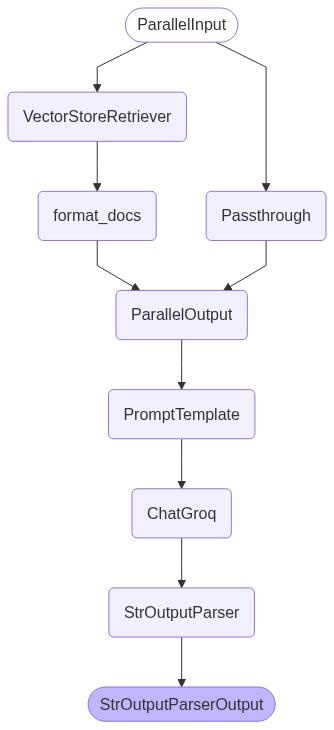

In [26]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | rag_prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [27]:
response = rag_chain.invoke("What two national anthems were sung on the day of the inauguration")
print(response)

The question is in English.

The two national anthems sung on the day of the inauguration were ‘Nkosi Sikelel’ iAfrika’ and ‘Die Stem’, the old anthem of the Republic.


In [28]:
rag_chain.invoke("কল্যাণী কোন ব্রত গ্রহণ করে?")

'দুঃখিত, উত্তর দেওয়ার মতো পর্যাপ্ত তথ্য আমার কাছে নেই।'

In [29]:
from langchain_community.utilities import GoogleSerperAPIWrapper

search = GoogleSerperAPIWrapper(serper_api_key="f1c2eb3b3d49414ac092b856ed315ccaade9f65c")

result = search.run("Current Prime Minister of Bangladesh")
print(result)

Sheikh Hasina was the longest-serving prime minister in the country's history until her forced resignation on 5 August 2024, which left the position vacant. Sheikh Hasina (née Wazed; born 28 September 1947) is a Bangladeshi politician who served as the tenth prime minister of Bangladesh from June 1996 to July 2001 ... Sheikh Hasina was sworn in for a fifth term as Bangladesh Prime Minister on January 11, 2024. She fled the country on August 5, 2024 following ... Sheikh Hasina, the deposed prime minister of Bangladesh and chair of Bangladesh Awami League [. EXPLAINER. Why the future of Bangladesh's Muhammad Yunus ... Sheikh Hasina was elected prime minister in 2009 and ruled Bangladesh with an iron fist. Members of her Awami League government ruthlessly ... Sheikh Hasina, the daughter of Sheikh Mujibur Rahman, has served as Prime Minister since January 6, 2009, making her the longest-serving leader in Bangladesh's ... “Sheikh Hasina is coming back as the Prime Minister”: Awami League le

In [30]:
from langchain_community.utilities import GoogleSerperAPIWrapper

search = GoogleSerperAPIWrapper(serper_api_key="f1c2eb3b3d49414ac092b856ed315ccaade9f65c")

In [31]:
search.run("কল্যাণী কোন ব্রত গ্রহণ করে?")

"১১। অনুপমের মামার মতে কাদের তেজ থাকাটা দোষের? - বেহাই সম্প্রদায়ের। ১২। বিয়ে ভাঙ্গার পর কল্যাণী কি গ্রহণ করেছে? - কল্যাণী নারীশিক্ষার ব্রত গ্রহণ করেছে। ১৩ ... [Question] কল্যাণী কিসের ব্রত গ্রহণ করেছে? ; (ক), দেশমাতৃকার সেবার ; (খ), দেশমাতাকে উদ্ধারের ; (গ), মেয়ে শিক্ষার ; (ঘ), সমাজ সংস্কারের ... কল্যাণী কিসের ব্রত গ্রহণ করেছে? দেশমাতৃকার সেবার দেশমাতাকে উদ্ধারের মেয়ে শিক্ষার সমাজ সংস্কারের সৌজন্যে: মনোয়ারা নার্সিং কলেজ, ঠাকুরগাঁও। কল্যাণী কিসের ব্রত গ্রহণ করেছে? ক. দেশমাতৃকার সেবার. খ. দেশমাতাকে উদ্ধারের. গ. মেয়ে শিক্ষার. ঘ. সমাজ সংস্কারের. Show Answer. কল্যাণী কিসের ব্রত গ্রহণ করেছে? সঠিক উত্তর. ক কল্যাণী মেয়েদের শিক্ষার ব্রত গ্রহণ করেছে । ... উদ্দীপকের অনিমেষের বাবা 'অপরিচিতা' গল্পের কোন চরিত্রের প্রতিনিধিত্ব করেন? সেই বিবাহ-ভাঙার পর হইতে কল্যাণী মেয়েদের শিক্ষার ব্রত গ্রহণ করিয়াছে । ... থেকে শুরু করে তাদের যত্ন করা, মনরক্ষা ইত্যাদি কাজও তাকেই সামাল দিতে হয়। উত্তর : বিবাহ ভাঙার পর থেকে কল্যাণী মেয়েদের শিক্ষার ব্রত গ্রহণ করেছে। প্রশ্ন ১২। অপরিচিতা' গল্পে কাকে গজাননের ছােট ভ

In [32]:
search.run("হরিশ কোথায় কাজ করে?")

'প্রশ্ন: হরিশ কোথায় কাজ করে? সঠিক উত্তর : কানপুরে. \'Earn by adding a description for the above question! ✨ ... ১। \'অপরিচিতা\' গল্পের হরিশ কোথায় কাজ করত? ক) কোলপুর খ) কানপুর]. গ) দিনাজপুর ঘ) ফতেহপুর. ২। প্রদোষ অর্থ কী ... হরিশ চন্দ্র রাজা ছিলেন একজন চাকমা রাজা যিনি ১৮৭৩ থেকে ১৮৮৪ সাল পর্যন্ত শাসন করেছিলেন। তিনি ছিলেন একজন অযোগ্য শাসক এবং তার শাসনকালে চাকমাদের মধ্যে বিদ্রোহ ছড়িয়ে পড়ে। উত্তর :হরিশ কানপুরে কাজ করে। \'লক্ষ্মী\' শব্দের অর্থ - · “আমি মাথা হেট করিয়া চুপ করিয়া রহিলাম” - উক্তিটি থেকে বোঝা যায় অনুপম -. i. মেরুদণ্ডহীন. ii. বিবেকবোধহীন. iii. ব্যক্তিত্বহীন. নিচের কোনটি সঠিক? · পাত্রের বাড়ির সবাই রেগে আগুন ... প্রশ্ন : ছুটিতে হরিশ কোথায় এসেছে? উত্তর : ছুটিতে হরিশ কলকাতায় এসেছে। প্রশ্ন : হরিশ অনুপমকে কী ধরনের মেয়ের সন্ধান দিয়েছিল? উত্তর : হরিশ অনুপমকে খাসা মেয়ের সন্ধান দিয়েছিল। প্রশ্ন : অবকাশের ... হরিশ কোথায় কাজ করে? ক) মালদহে খ) বীরভূমে গ) কানপুরে ঘ) ভুজপুরে · Sanjida Tasmin · Raju Ahamed · Aj Mizanur Rahman · JM Ankhi · Mohona Islam Munni · Md. Rakib Ahmmed. অপরিচ

In [33]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [34]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [35]:
wikipedia.invoke("bangladesh")

'Page: Bangladesh\nSummary: Bangladesh, officially the People\'s Republic of Bangladesh, is a country in South Asia. It is the eighth-most populous country in the world and among the most densely populated with a population of over 171 million within an area of 148,460 square kilometres (57,320 sq mi). Bangladesh shares land borders with India to the north, west, and east, and Myanmar to the southeast. It has a coastline along the Bay of Bengal to its south and is separated from Bhutan and Nepal by the Siliguri Corridor, and from China by the Indian state of Sikkim to its north. Dhaka, the capital and largest city, is the nation\'s political, financial, and cultural centre. Chittagong is the second-largest city and the busiest port of the country. \nThe territory of modern Bangladesh was a stronghold of many Buddhist and Hindu dynasties in ancient history. Following the Muslim conquest in 1204, the region saw Sultanate and Mughal rule. During the Mughal period, particularly under the B

In [36]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["TAVILY_API_KEY"] = "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"
tool = TavilySearchResults()
print(tool.run("Current president of Bangladesh"))


C:\Users\nahid\AppData\Local\Temp\ipykernel_5696\2664684933.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults()


[{'title': 'Mohammed Shahabuddin - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Mohammed_Shahabuddin', 'content': 'Bangladesh\n\nMohammed Shahabuddin (born 10 December 1949) is a Bangladeshi jurist, journalist, civil servant and politician who has served as the 16th and current president of Bangladesh since 2023. He was elected unopposed in the 2023 presidential election as the nominee of the ruling Awami League. Prior to his presidency, Shahabuddin served as a district and sessions judge and a commissioner of the Anti-Corruption Commission "Anti-Corruption Commission (Bangladesh)") from 2011 to 2016. [...] | His Excellency  Mohammed Shahabuddin | |\n| --- | --- |\n| মোহাম্মদ সাহাবুদ্দিন | |\n| Shahabuddin in 2023 | |\n|  | |\n| 17th President of Bangladesh | |\n| Incumbent | |\n| Assumed office  24 April 2023 | |\n| Prime Minister |  Sheikh Hasina  Muhammad Yunus (Interim) |\n| Preceded by | Mohammad Abdul Hamid |\n|  | |\n| Personal details | |\n| Born | (1949-12-10) 10 December

In [37]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [38]:
tool.invoke("হরিশ কোথায় কাজ করে?")

{'query': 'হরিশ কোথায় কাজ করে?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://sattacademy.com/academy/written/%E0%A6%B9%E0%A6%B0%E0%A6%BF%E0%A6%B6-%E0%A6%95%E0%A7%8B%E0%A6%A5%E0%A6%BE%E0%A6%AF%E0%A6%BC-%E0%A6%95%E0%A6%BE%E0%A6%9C-%E0%A6%95%E0%A6%B0%E0%A7%87-23855',
   'title': 'হরিশ কোথায় কাজ করে? (জ্ঞানমূলক) - Satt Academy',
   'content': 'উত্তর :হরিশ কানপুরে কাজ করে।',
   'score': 0.8914433,
   'raw_content': None},
  {'url': 'https://sattacademy.com/admission/single-question?ques_id=280613',
   'title': 'হরিশ কোথায় কাজ করে? - Satt Academy',
   'content': "প্রশ্ন: হরিশ কোথায় কাজ করে? সঠিক উত্তর : কানপুরে. 'Earn by adding a description for the above question! ✨",
   'score': 0.8377398,
   'raw_content': None},
  {'url': 'https://www.ittefaq.com.bd/29051/%E2%80%98%E0%A6%85%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BE%E2%80%99-%E0%A6%97%E0%A6%B2%E0%A7%8D%E0%A6%AA%E0%A7%87%E0%A6%B0-%E0%A6%B9%E0%A6%B0%E0%A6%BF%E0%A6%B6-%

In [39]:
tool.invoke("অপরিচিতা” প্রথম প্রকাশিত হয় প্রমথ চৌধুরী সম্পাদিত মাসিক 'সবুজপত্র' পত্রিকার ১৩২১ বঙ্গাব্দের (১৯১৪) কার্তিক সংখ্যায়।")

{'query': "অপরিচিতা” প্রথম প্রকাশিত হয় প্রমথ চৌধুরী সম্পাদিত মাসিক 'সবুজপত্র' পত্রিকার ১৩২১ বঙ্গাব্দের (১৯১৪) কার্তিক সংখ্যায়।",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.facebook.com/hscsug/posts/%E0%A6%85%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BE-%E0%A6%97%E0%A6%B2%E0%A7%8D%E0%A6%AA%E0%A7%87%E0%A6%B0-%E0%A6%AC%E0%A7%8D%E0%A6%AF%E0%A6%BE%E0%A6%96%E0%A7%8D%E0%A6%AF%E0%A6%BE-%E0%A6%93-%E0%A6%AE%E0%A7%82%E0%A6%B2%E0%A6%AD%E0%A6%BE%E0%A6%AC%E0%A6%85%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BE-%E0%A6%97%E0%A6%B2%E0%A7%8D%E0%A6%AA%E0%A7%87%E0%A6%B0-%E0%A6%AE%E0%A7%82%E0%A6%B2%E0%A6%AD%E0%A6%BE%E0%A6%AC%E0%A6%85%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BE-%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A6%A5%E0%A6%AE-%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A6%95%E0%A6%BE%E0%A6%B6%E0%A6%BF%E0%A6%A4-%E0%A6%B9/612823854966558/',
   'title': "এ এবং পরে, 'গল্পগুচ্ছ' তৃতীয় খণ্ডে (১৯২৭)। “অপরিচিতা” গল্পে ... -